In [139]:
import pandas as pd
import numpy as np
import billboard
import datetime as datetime
import warnings
import copy
import random
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
%matplotlib inline

In [2]:
%run all_code_more_lags.py

In [35]:
df = pd.read_csv('data_safe/df_at_for_models_714.csv').drop('Unnamed: 0', axis=1)

In [48]:
# adds n lags and n-1 delta of data['position']
# assumed to start with lag_1 and lag_2 in place
# fills NaN with '51'
def add_lags(n, df1=df):
    data = copy.deepcopy(df1)
    for i in range(3, n+1):
        data[f'lag_{i}'] = data['position'].shift(i)
        data.fillna(51, inplace=True)
        data[f'delta_{i}'] = data[f'lag_{i}'] - data[f'lag_{i-1}']
    return data

In [49]:
df_10 = add_lags(10)

In [51]:
df_5 = add_lags(5)

In [52]:
df_15 = add_lags(15)

In [13]:
# using Pipeline for scaling
px = Pipeline ([
        ('ss', StandardScaler()),
        ('clf', XGBClassifier())
        
])

In [108]:
def tts(data, target = 'move_2n'):
    feats = ['position', 'weeks_on_chart', 'peak_lag', 'weeks_lag'] + [c for c in data.columns if ('delta_' in c)]
    drop_cols = [c for c in data.columns if c not in feats]
    
    target = target
    
    X = data.drop(drop_cols, axis=1)
    y = data.loc[:, target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return(X_train, X_test, y_train, y_test)

In [109]:
# takes data and a model
# runs train test split, fits on the training data
# gives the train score, the test score and runs classy() on test data
def reg_test(data, model):
    X_train, X_test, y_train, y_test = tts(data)
    model.fit(X_train, y_train)
    print(f'Train score: {model.score(X_train, y_train)}')
    print(f'Test score: {model.score(X_test, y_test)}')
    classy(X_test, y_test, px)
    return

Train score: 0.6398344494047619
Test score: 0.6334216766634119
             precision    recall  f1-score   support

       -1.0       0.71      0.65      0.68      2414
        0.0       0.53      0.25      0.34      1843
        1.0       0.62      0.86      0.72      2912

avg / total       0.62      0.63      0.61      7169

 1.0    4082
-1.0    2205
 0.0    882 
Name: 0, dtype: int64


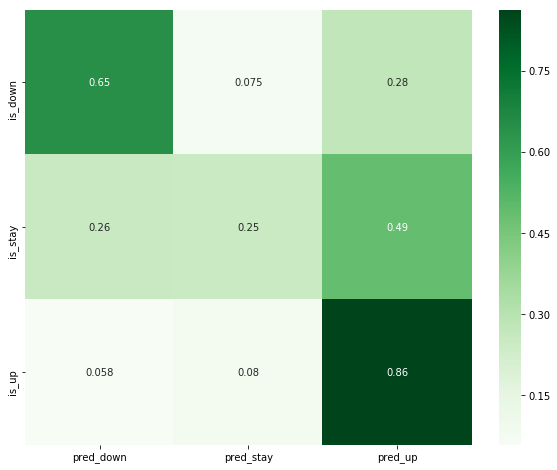

In [110]:
reg_test(df, px)

Train score: 0.6385323660714286
Test score: 0.6384432975310365
             precision    recall  f1-score   support

       -1.0       0.74      0.67      0.70      2484
        0.0       0.54      0.25      0.34      1880
        1.0       0.60      0.87      0.71      2805

avg / total       0.63      0.64      0.61      7169

 1.0    4036
-1.0    2267
 0.0    866 
Name: 0, dtype: int64


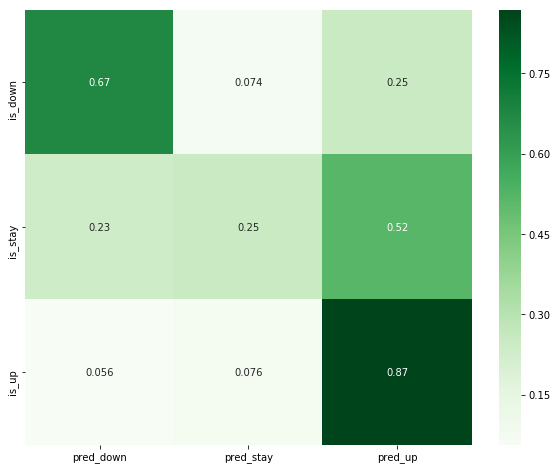

In [111]:
reg_test(df_5, px)

Train score: 0.6417410714285714
Test score: 0.6334216766634119
             precision    recall  f1-score   support

       -1.0       0.70      0.67      0.68      2398
        0.0       0.53      0.25      0.34      1842
        1.0       0.62      0.85      0.71      2929

avg / total       0.62      0.63      0.61      7169

 1.0    4030
-1.0    2277
 0.0    862 
Name: 0, dtype: int64


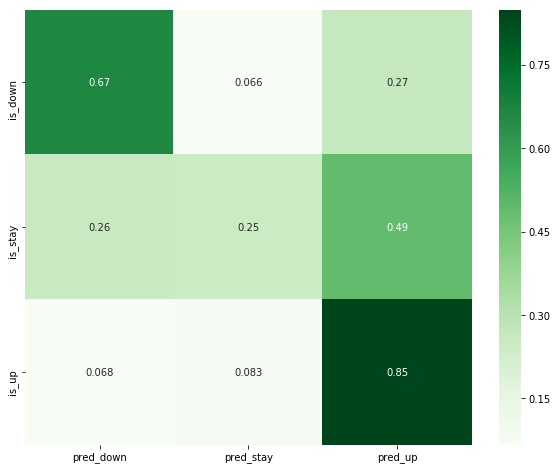

In [112]:
reg_test(df_10, px)

Train score: 0.6427176339285714
Test score: 0.6327242293206863
             precision    recall  f1-score   support

       -1.0       0.70      0.68      0.69      2460
        0.0       0.54      0.24      0.34      1863
        1.0       0.61      0.85      0.71      2846

avg / total       0.62      0.63      0.61      7169

 1.0    3955
-1.0    2368
 0.0    846 
Name: 0, dtype: int64


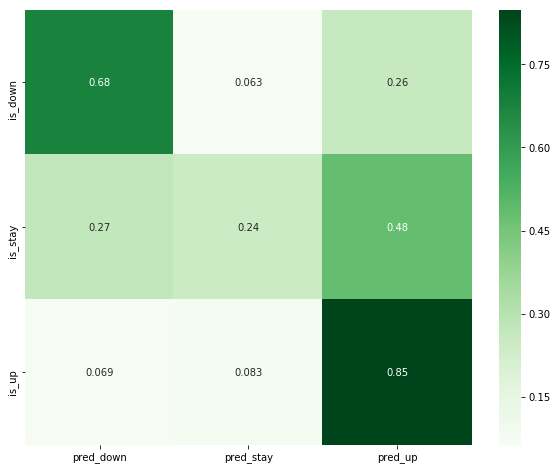

In [113]:
reg_test(df_15, px)

In [114]:
def proboy(data, model):
    X_train, X_test, y_train, y_test = tts(data)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    outs = pd.concat([X_test, y_test], axis=1)
    outs['down_proba'] = preds[:,0]
    outs['stay_proba'] = preds[:,1]
    outs['up_proba'] = preds[:,2]
    outs  = pd.merge(outs, data[['key','artist']],
                     how='inner', left_index=True, right_index=True).drop('artist', axis=1)
    return outs

In [115]:
df_2_outs = proboy(df, px)
df_5_outs = proboy(df_5, px)
df_10_outs = proboy(df_10, px)
df_15_outs = proboy(df_15, px)

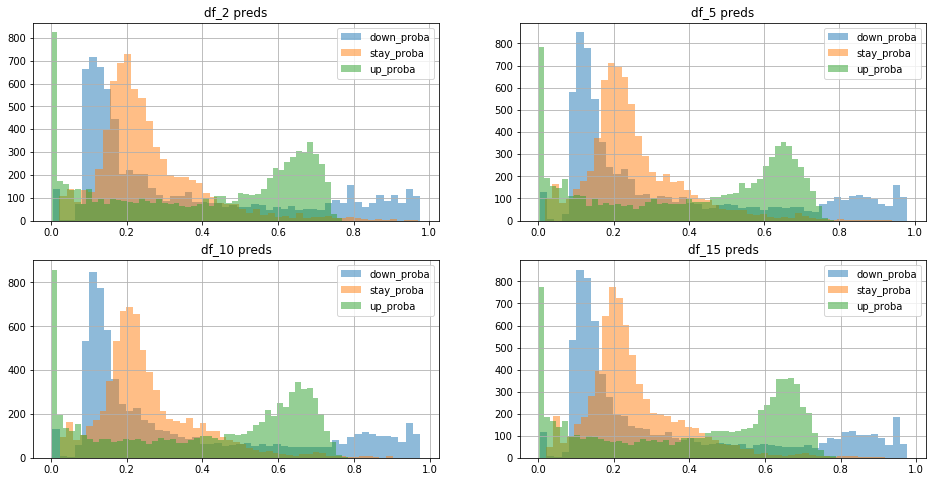

In [124]:
# hists of xgb predict proba by number of lags
fig = plt.figure(figsize=(16,8))
dirs = ['down_proba', 'stay_proba', 'up_proba']
ms = ['df_2', 'df_5', 'df_10', 'df_15']

kwargs = dict(alpha=0.5, bins=50, density=False, cumulative=False)

for o in ms:
    plt.subplot(2,2,ms.index(o)+1)
    d = eval(f'{o}_outs')
    plt.title(s=f'{o} preds')
    d.down_proba.hist(**kwargs)
    d.stay_proba.hist(**kwargs)
    d.up_proba.hist(**kwargs)
    plt.legend(['down_proba', 'stay_proba', 'up_proba']);
    # plt.xlim(0,1) 
    


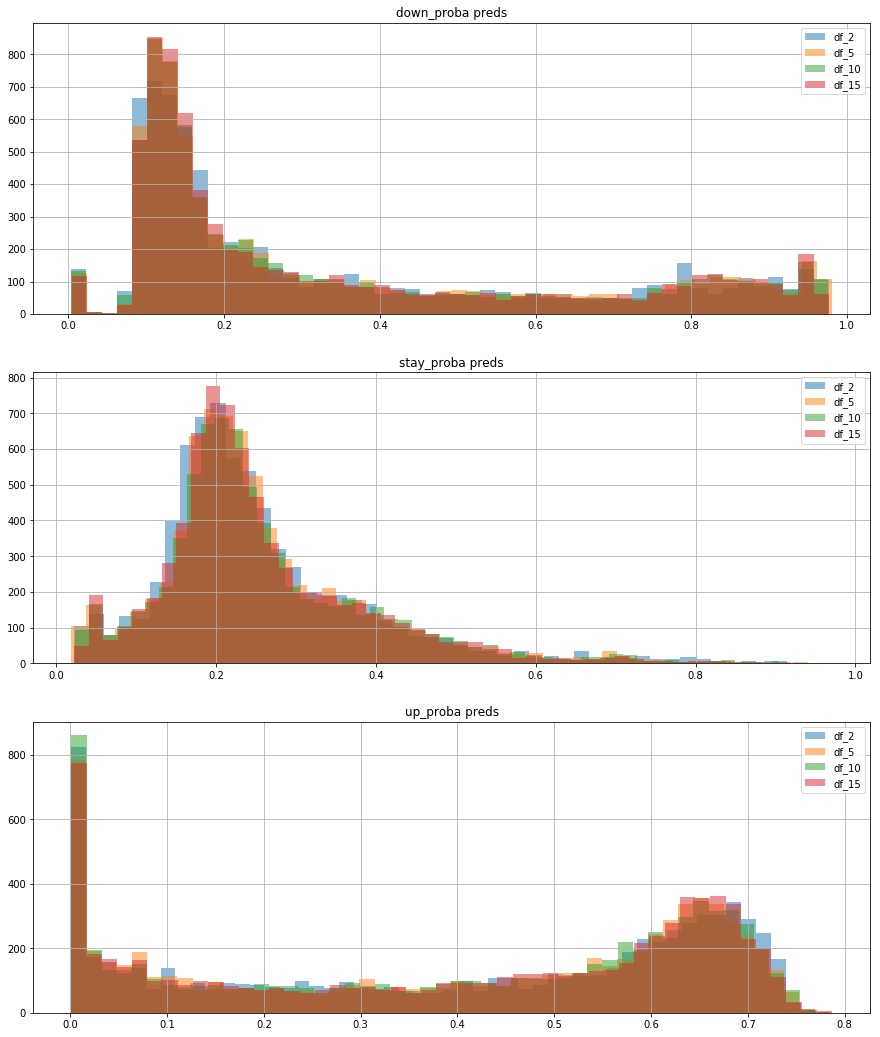

In [127]:
# hists of xgb predict proba for number of lags separated by direction
fig = plt.figure(figsize=(15,10))
dirs = ['down_proba', 'stay_proba', 'up_proba']
ms = ['df_2', 'df_5', 'df_10', 'df_15']

kwargs = dict(alpha=0.5, bins=50, rwidth=1, density=False, cumulative=False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5,
                wspace=None, hspace=None)
for v in dirs:
    plt.subplot(3,1,dirs.index(v)+1)
    plt.title(s=f'{v} preds')
    df_2_outs[v].hist(**kwargs)
    df_5_outs[v].hist(**kwargs)
    df_10_outs[v].hist(**kwargs)
    df_15_outs[v].hist(**kwargs)
    plt.legend(ms);

#     for m in ms:
#         d = eval(f'{m}_outs')
#         d[v].hist(bins=b, density=dz, alpha=a, rwidth=0.1)
#         plt.legend(ms);


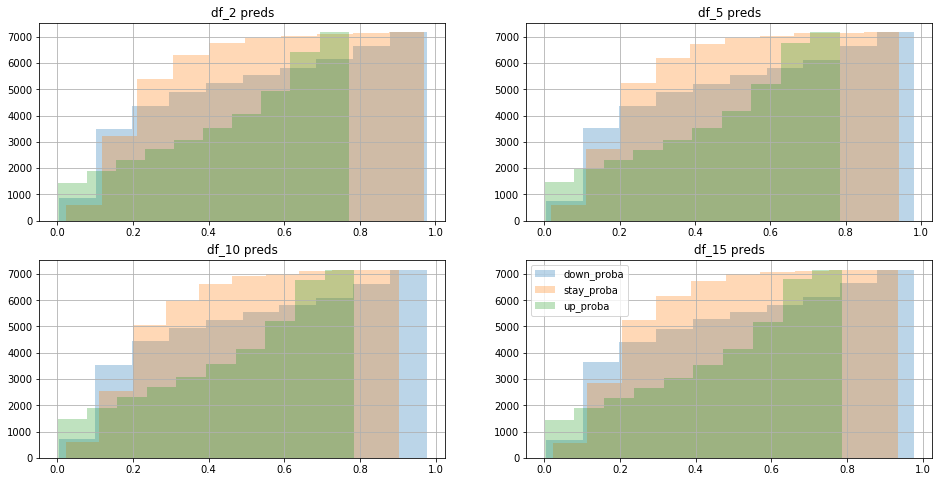

In [128]:
# hists of xgb predict proba by number of lags
# cumulative
fig = plt.figure(figsize=(16,8))
dirs = ['down_proba', 'stay_proba', 'up_proba']
ms = ['df_2', 'df_5', 'df_10', 'df_15']

kwargs = dict(alpha=0.3, bins=10, rwidth=1, density=False, cumulative=True)

for o in ms:
    plt.subplot(2,2,ms.index(o)+1)
    d = eval(f'{o}_outs')
    plt.title(s=f'{o} preds')
    d.down_proba.hist(**kwargs)
    d.stay_proba.hist(**kwargs)
    d.up_proba.hist(**kwargs)
    # plt.xlim(0,1) 
    
plt.legend(['down_proba', 'stay_proba', 'up_proba']);

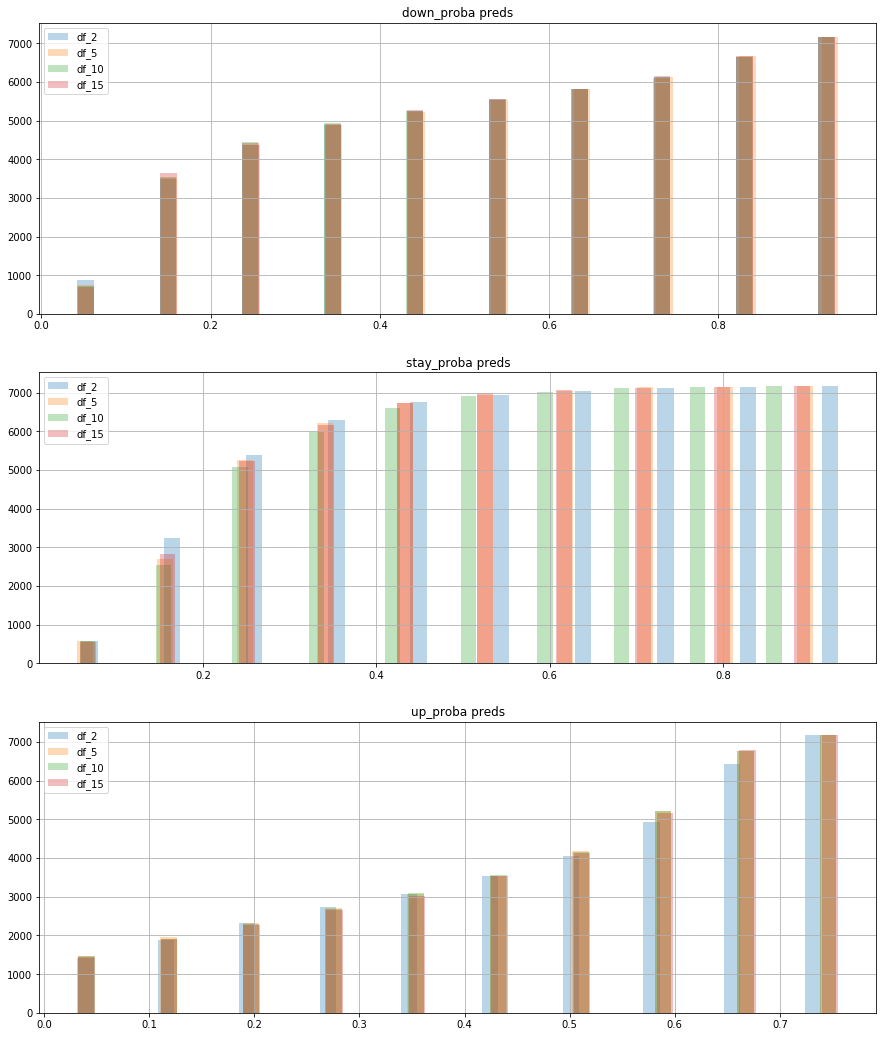

In [129]:
# hists of xgb predict proba for number of lags separated by direction
# cumulative
fig = plt.figure(figsize=(15,10))
dirs = ['down_proba', 'stay_proba', 'up_proba']
ms = ['df_2', 'df_5', 'df_10', 'df_15']

kwargs = dict(alpha=0.3, bins=10, rwidth=0.2, density=False, cumulative=True)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5,
                wspace=None, hspace=None)
for v in dirs:
    plt.subplot(3,1,dirs.index(v)+1)
    plt.title(s=f'{v} preds')
    df_2_outs[v].hist(**kwargs)
    df_5_outs[v].hist(**kwargs)
    df_10_outs[v].hist(**kwargs)
    df_15_outs[v].hist(**kwargs)
    plt.legend(ms);

In [149]:
def tts_by_key(data, target = 'move_2n', test_size=0.3):
    # create key list
    key_list = data.key.unique()

    # set features and target
    feats = ['key','position', 'weeks_on_chart', 'peak_lag', 'weeks_lag'] + [c for c in data.columns if ('delta_' in c)]
    drop_cols = [c for c in data.columns if c not in feats]
    
    target = target

    # shuffle unique keys
    random.shuffle(key_list)

    # define split percentage
    l = int(len(key_list)*test_size)

    # subset train and test
    test_keys = key_list[:l]
    train_keys = key_list[l:]

    df_train = data[data['key'].isin(train_keys)]
    df_test = data[data['key'].isin(test_keys)]

    X_train = df_train[feats]
    y_train = df_train[target]
    X_test = df_test[feats]
    y_test = df_test[target]
    return(X_train, X_test, y_train, y_test)

In [148]:
# to preserve splits, submit tts_by_key results instead of running tts_by_key again
def proboy_by_key(model, data, train_keys, test_keys, target = 'move_2n'):
    df_train = data[data['key'].isin(train_keys)]
    df_test = data[data['key'].isin(test_keys)]
    
    feats = ['position', 'weeks_on_chart', 'peak_lag', 'weeks_lag'] + [c for c in data.columns if ('delta_' in c)]
    target = 'move_2n'
    
    X_train = df_train[feats]
    y_train = df_train[target]
    X_test = df_test[feats]
    y_test = df_test[target]
    
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    outs = pd.concat([X_test, y_test], axis=1)
    outs['down_proba'] = preds[:,0]
    outs['stay_proba'] = preds[:,1]
    outs['up_proba'] = preds[:,2]
    outs  = pd.merge(outs, data[['key','artist','chart_date']],
                     how='inner', left_index=True, right_index=True)
    return outs

In [151]:
X_train, X_test, y_train, y_test = tts_by_key(df)
train_keys = X_train['key'].unique()
test_keys = X_test['key'].unique()

df_2_outs_key = proboy_by_key(px, df, train_keys, test_keys)
df_5_outs_key = proboy_by_key(px, df_5, train_keys, test_keys)
df_10_outs_key = proboy_by_key(px, df_10, train_keys, test_keys)
df_15_outs_key = proboy_by_key(px, df_15, train_keys, test_keys)

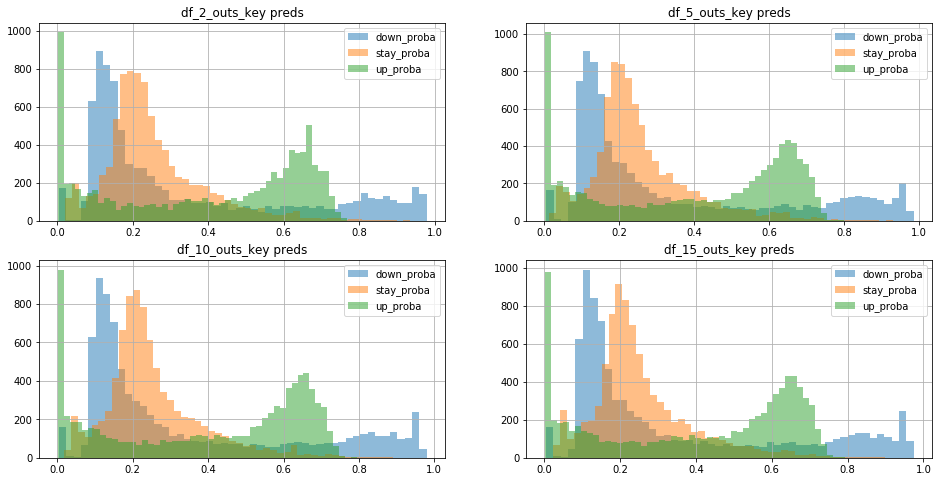

In [154]:
# hists of xgb predict proba by number of lags
fig = plt.figure(figsize=(16,8))
dirs = ['down_proba', 'stay_proba', 'up_proba']
ms = ['df_2', 'df_5', 'df_10', 'df_15']

kwargs = dict(alpha=0.5, bins=50, density=False, cumulative=False)

for o in ms:
    plt.subplot(2,2,ms.index(o)+1)
    d = eval(f'{o}_outs_key')
    plt.title(s=f'{o}_outs_key preds')
    d.down_proba.hist(**kwargs)
    d.stay_proba.hist(**kwargs)
    d.up_proba.hist(**kwargs)
    plt.legend(['down_proba', 'stay_proba', 'up_proba']);
    # plt.xlim(0,1) 

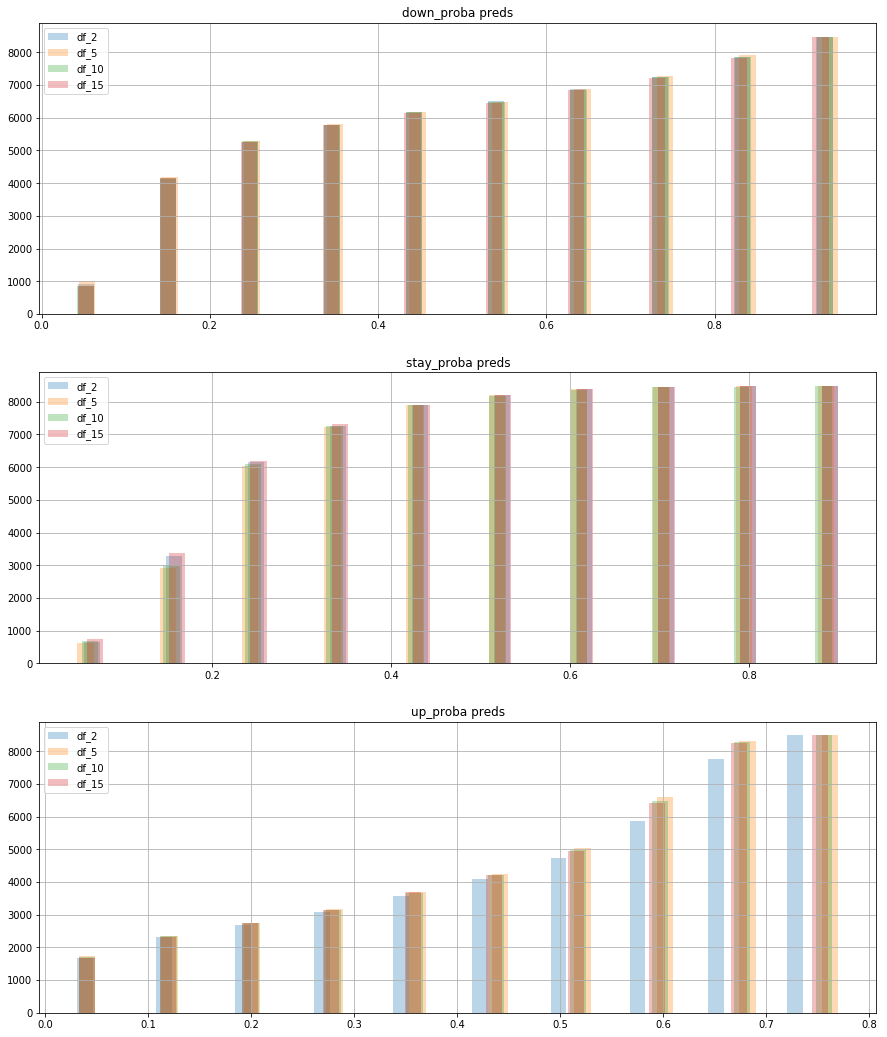

In [155]:
# hists of xgb predict proba for number of lags separated by direction
# cumulative
fig = plt.figure(figsize=(15,10))
dirs = ['down_proba', 'stay_proba', 'up_proba']
ms = ['df_2', 'df_5', 'df_10', 'df_15']

kwargs = dict(alpha=0.3, bins=10, rwidth=0.2, density=False, cumulative=True)

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5,
                wspace=None, hspace=None)
for v in dirs:
    plt.subplot(3,1,dirs.index(v)+1)
    plt.title(s=f'{v} preds')
    df_2_outs_key[v].hist(**kwargs)
    df_5_outs_key[v].hist(**kwargs)
    df_10_outs_key[v].hist(**kwargs)
    df_15_outs_key[v].hist(**kwargs)
    plt.legend(ms);

In [176]:
def chart_proba(key, data, fig=True, legend=True, title=True):
    d1 = data[data['key'] == key].sort_values('chart_date').reset_index()
    if fig:
        fig = plt.figure(figsize=(17,10))
    if title:
        plt.title(s=key)
    z_inc = 0.3
    z = 0-z_inc
    for p in ['down_proba', 'stay_proba', 'up_proba']:
        plt.bar(data=d1, x=d1['index']+z, height=d1[p]*100, alpha=0.4, width=z_inc)
        z += z_inc
    plt.scatter(data=d1, x='index', y='position')
    if legend:
        plt.legend(['chart position','down_proba', 'stay_proba', 'up_proba'])
    plt.xticks([]);
    return

In [165]:
def artist_charts_proba(artist, data):
    keys = data[data['artist'] == artist]['key'].unique()
    l = len(keys)
    rows = int(l/2)+1
    cols = 2
    p = 1
    fig = plt.figure(figsize=(15,15))
    for k in keys:
        plt.subplot(rows, cols, p)
        chart_proba(k, data, fig=False, legend=False)
        p += 1
    return

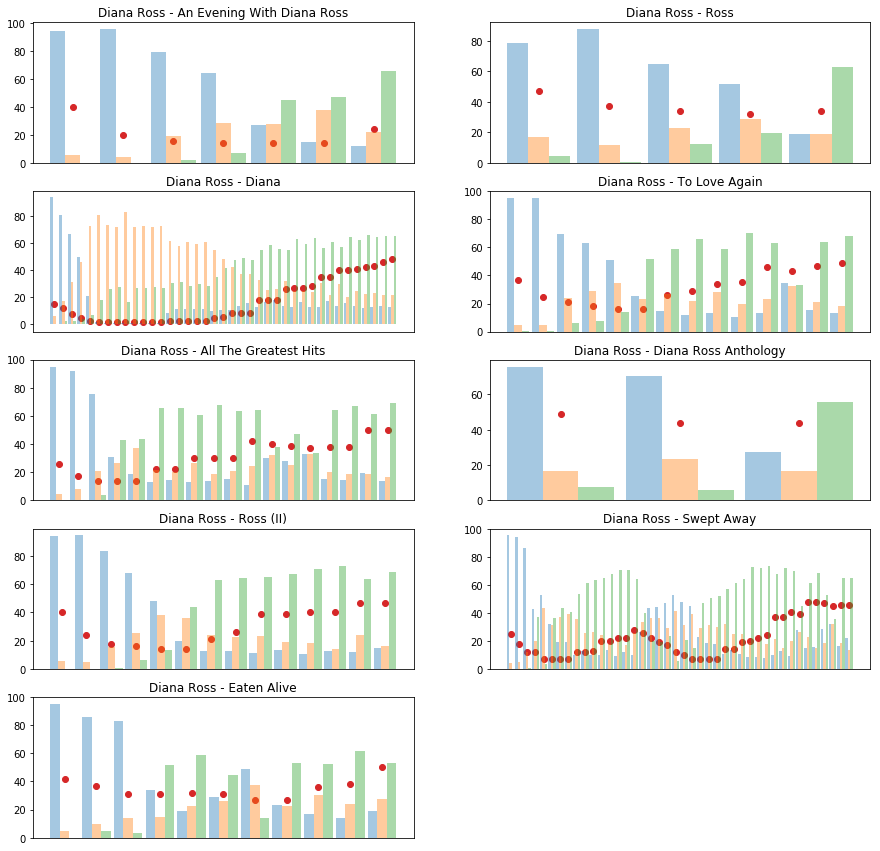

In [166]:
artist_charts_proba('Diana Ross', df_10_outs_key)

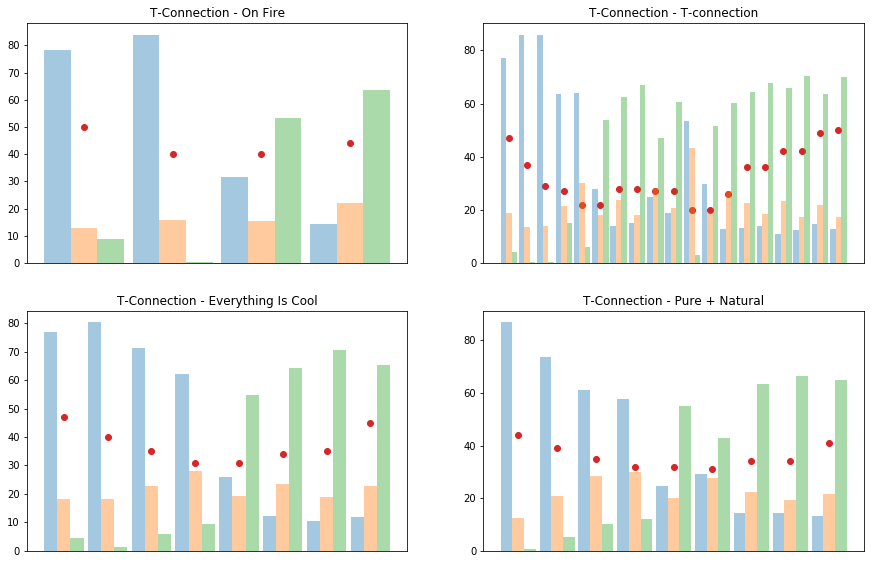

In [200]:
artist_charts_proba('T-Connection', df_10_outs_key)

In [206]:
def lags_barplots(key):
    ms = ['df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']
    dirs = ['down_proba', 'stay_proba', 'up_proba']
    p = 1
    fig = plt.figure(figsize=(15,18))
    for v in dirs:
        plt.subplot(3,1, p)
        plt.title(s=f'{key}, {v}')
        z_inc = 0.2
        z = 0-z_inc
        for m in ms:
            data = eval(f'{m}')
            d1 = data[data['key'] == key].sort_values('chart_date').reset_index()
            plt.bar(data=d1, x=d1['index']+z, height=d1[v]*100, alpha=0.4, width=z_inc)
            z += z_inc
        plt.scatter(data=d1, x='index', y='position')
        plt.xticks([])
        plt.ylim(-2, 100)
        p +=1 
    plt.legend(['chart position','df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']);

In [169]:
df_2_outs_key[['artist','key']].drop_duplicates().groupby('artist').count().sort_values('key', ascending=False)

key
artist                         
Diana Ross                  9  
Gladys Knight And The Pips  7  
Soundtrack                  7  
Millie Jackson              6  
The Temptations             6  
Aretha Franklin             5  
Grover Washington, Jr.      5  
George Duke                 5  
The Isley Brothers          5  
Earth, Wind & Fire          5  
Commodores                  5  
Ashford & Simpson           5  
The Manhattans              4  
Barry White                 4  
David Sanborn               4  
Curtis Mayfield             4  
T-Connection                4  
James Brown                 4  
ConFunkShun                 4  
Brass Construction          4  
Spyro Gyra                  4  
Donna Summer                4  
Earl Klugh                  4  
Smokey Robinson             4  
Minnie Riperton             4  
The Dells                   4  
The Fatback Band            4  
Rufus And Chaka Khan        4  
The Staple Singers          3  
Michael Jackson             3  
...                        ..  
Isaac Hayes                 1  
George McCrae               1  
Gino Vannelli               1  
Glenn Jones                 1  
Grace Jones                 1  
Graham Central Station      1  
Grey And Hanks              1  
Gwen Guthrie                1  
Heatwave                    1  
Heaven And Earth            1  
Herb Alpert                 1  
Herbie Hancock              1  
Herbie Mann                 1  
Howard Johnson              1  
Isaac Hayes Movement        1  
Kiddo                       1  
Jackie Moore                1  
Jackson 5                   1  
Janet Jackson               1  
Jeff Lorber Fusion          1  
Jenny Burton                1  
Jermaine Jackson            1  
Jimmie Walker/Esther Rolle  1  
Jimmy 'Bo' Horne            1  
Jimmy Witherspoon           1  
John Tropea                 1  
Johnnie Taylor              1  
Johnny Mathis               1  
KC And The Sunshine Band    1  
Zapp                        1  

[346 rows x 1 columns]

In [210]:
df_2_outs_key[['key','weeks_on_chart']].groupby('key').max()

weeks_on_chart
key                                                                            
"Weird Al" Yankovic - "Weird Al" Yankovic In 3-D                 2             
5 Special - Special Edition                                      4             
9.9 - 9.9                                                        16            
Aalon - Cream City                                               4             
Ahmad Jamal - Jamal Plays Jamal                                  2             
Al Green - Al Green's Greatest Hits Volume II                    2             
Al Green - Full Of Fire                                          11            
Al Green - Truth N' Time                                         3             
Al Jarreau - High Crime                                          18            
Albert King - Truckload Of Lovin'                                9             
Alex Haley - Alex Haley Tells The Story Of His Search For Roots  1             
Alicia Bridges - Alicia Bridges                                  12            
Alphonse Mouzon - Distant Lover                                  14            
Alton McClain & Destiny - Alton Mc Clain + Destiny               8             
Andrae Crouch - I'll Be Thinking Of You                          2             
Andre Cymone - Livin' In The New Wave                            1             
Angela Bofill - Angel Of The Night                               30            
Angela Bofill - Angie                                            16            
Angela Bofill - Teaser                                           19            
Anita Baker - The Songstress                                     41            
Archie Bell & The Drells - Dance Your Troubles Away              19            
Archie Bell & The Drells - Strategy                              4             
Aretha Franklin - Aretha                                         32            
Aretha Franklin - Love All The Hurt Away                         18            
Aretha Franklin - Sweet Passion                                  21            
Aretha Franklin - With Everything I Feel In Me                   11            
Aretha Franklin - You                                            12            
Ashford & Simpson - A Musical Affair                             12            
Ashford & Simpson - Is It Still Good To Ya                       26            
Ashford & Simpson - Performance                                  2             
...                                                              ..            
Trouble Funk - Drop The Bomb                                     3             
Twennynine Featuring Lenny White - Twennynine With Lenny White   5             
Tyrone Davis - In The Mood With Tyrone Davis                     20            
UTFO - UTFO                                                      19            
Undisputed Truth - Method To The Madness                         12            
Unlimited Touch - Unlimited Touch                                7             
Val Young - Seduction                                            3             
Van Mccoy - From Disco To Love                                   4             
Van Mccoy - Real Mccoy                                           4             
Van Mccoy - The Disco Kid                                        5             
Various Artists - Casino Lights                                  12            
Various Artists - Echoes Of An Era                               3             
Vaughn Mason And Crew - Bounce Rock Skate Roll                   9             
Vernon Burch - Playing Hard To Get                               1             
Village People - Macho Man                                       26            
Weather Report - Black Market                                    5             
Weather Report - Heavy Weather                                   2             
Weather Report - Procession                                      

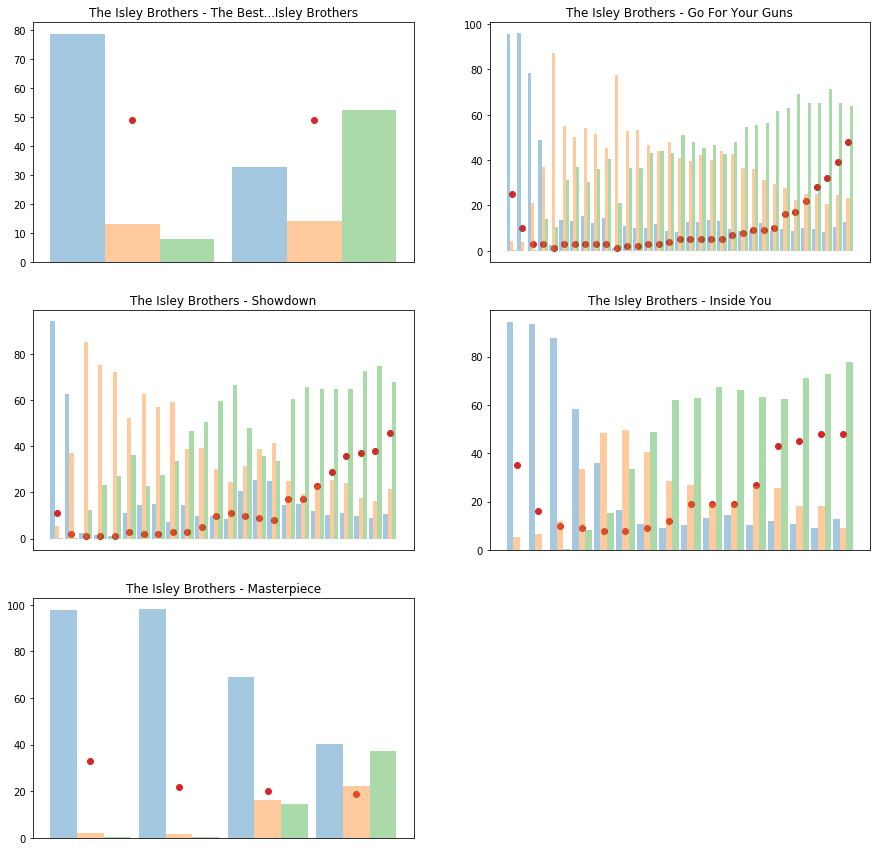

In [171]:
artist_charts_proba('The Isley Brothers', df_10_outs_key)

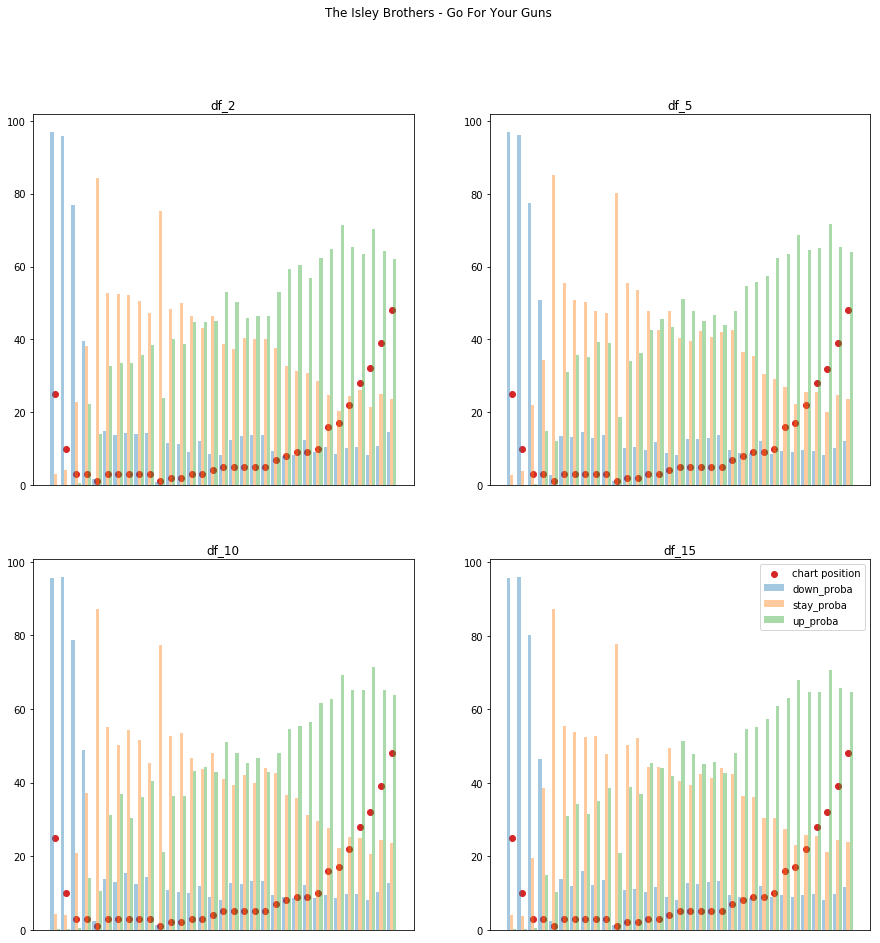

In [181]:
ms = ['df_2', 'df_5', 'df_10', 'df_15']
key = 'The Isley Brothers - Go For Your Guns'
p = 1
fig = plt.figure(figsize=(15,15))
plt.suptitle(t=key)
for m in ms:
    plt.subplot(2,2, p)
    chart_proba(key, eval(f'{m}_outs_key'), fig=False, title=False, legend=False)
    plt.title(s=m)
    p +=1 
plt.legend(['chart position','down_proba', 'stay_proba', 'up_proba']);

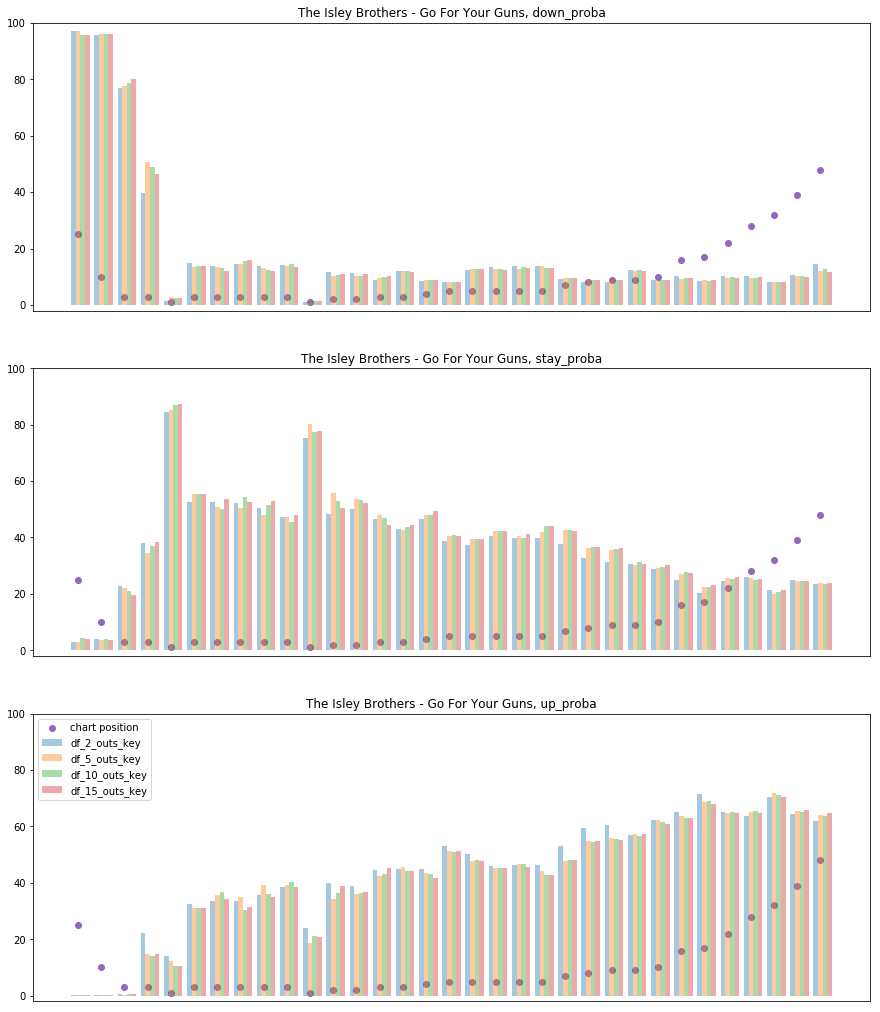

In [198]:
ms = ['df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']
dirs = ['down_proba', 'stay_proba', 'up_proba']
key = 'The Isley Brothers - Go For Your Guns'
p = 1
fig = plt.figure(figsize=(15,18))
for v in dirs:
    plt.subplot(3,1, p)
    plt.title(s=f'{key}, {v}')
    z_inc = 0.2
    z = 0-z_inc
    for m in ms:
        data = eval(f'{m}')
        d1 = data[data['key'] == key].sort_values('chart_date').reset_index()
        plt.bar(data=d1, x=d1['index']+z, height=d1[v]*100, alpha=0.4, width=z_inc)
        z += z_inc
    plt.scatter(data=d1, x='index', y='position')
    plt.xticks([])
    plt.ylim(-2, 100)
    p +=1 
plt.legend(['chart position','df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']);

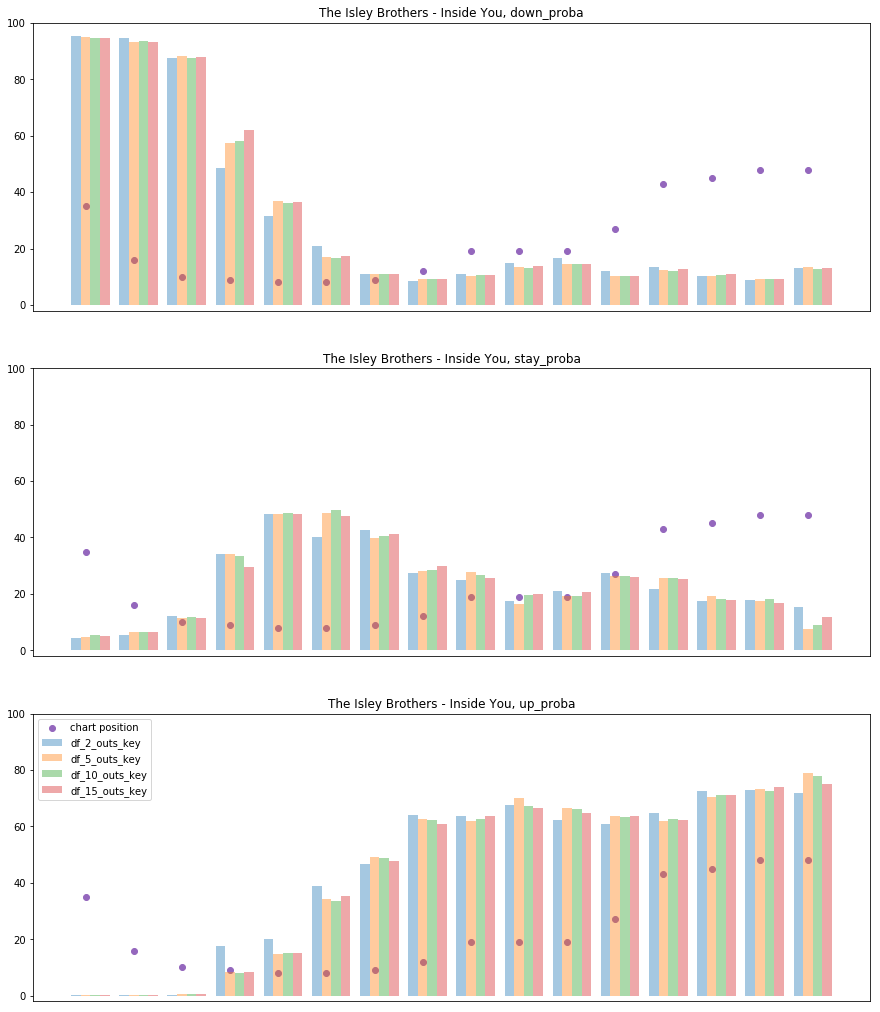

In [199]:
ms = ['df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']
dirs = ['down_proba', 'stay_proba', 'up_proba']
key = 'The Isley Brothers - Inside You'
p = 1
fig = plt.figure(figsize=(15,18))
for v in dirs:
    plt.subplot(3,1, p)
    plt.title(s=f'{key}, {v}')
    z_inc = 0.2
    z = 0-z_inc
    for m in ms:
        data = eval(f'{m}')
        d1 = data[data['key'] == key].sort_values('chart_date').reset_index()
        plt.bar(data=d1, x=d1['index']+z, height=d1[v]*100, alpha=0.4, width=z_inc)
        z += z_inc
    plt.scatter(data=d1, x='index', y='position')
    plt.xticks([])
    plt.ylim(-2, 100)
    p +=1 
plt.legend(['chart position','df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']);

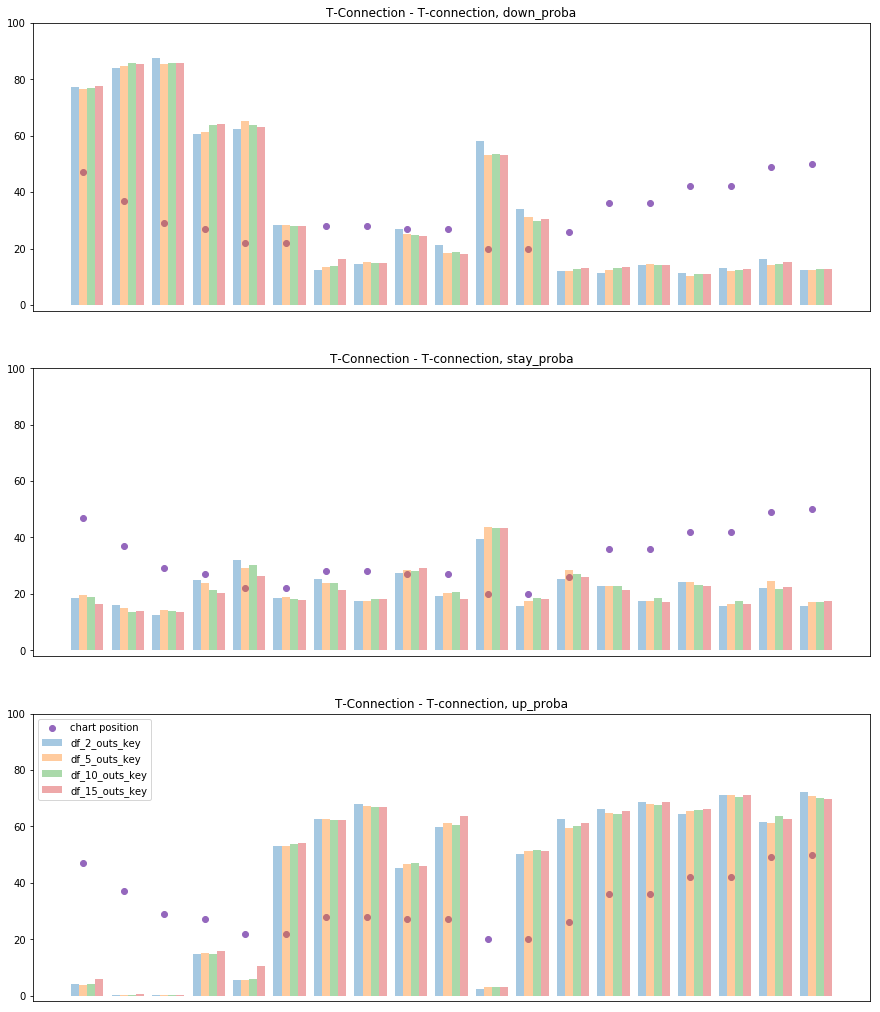

In [204]:
ms = ['df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']
dirs = ['down_proba', 'stay_proba', 'up_proba']
key = 'T-Connection - T-connection'
p = 1
fig = plt.figure(figsize=(15,18))
for v in dirs:
    plt.subplot(3,1, p)
    plt.title(s=f'{key}, {v}')
    z_inc = 0.2
    z = 0-z_inc
    for m in ms:
        data = eval(f'{m}')
        d1 = data[data['key'] == key].sort_values('chart_date').reset_index()
        plt.bar(data=d1, x=d1['index']+z, height=d1[v]*100, alpha=0.4, width=z_inc)
        z += z_inc
    plt.scatter(data=d1, x='index', y='position')
    plt.xticks([])
    plt.ylim(-2, 100)
    p +=1 
plt.legend(['chart position','df_2_outs_key', 'df_5_outs_key', 'df_10_outs_key', 'df_15_outs_key']);

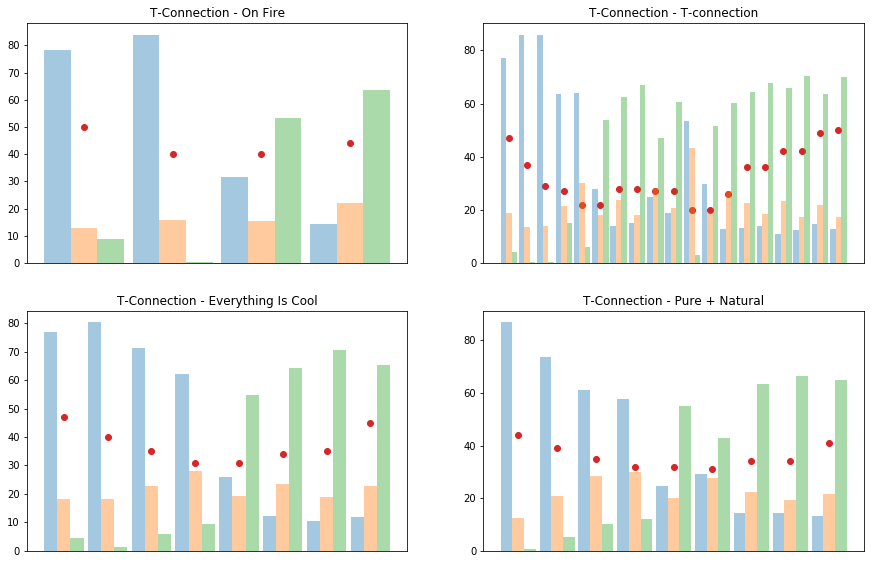

In [202]:
artist_charts_proba('T-Connection', df_10_outs_key)

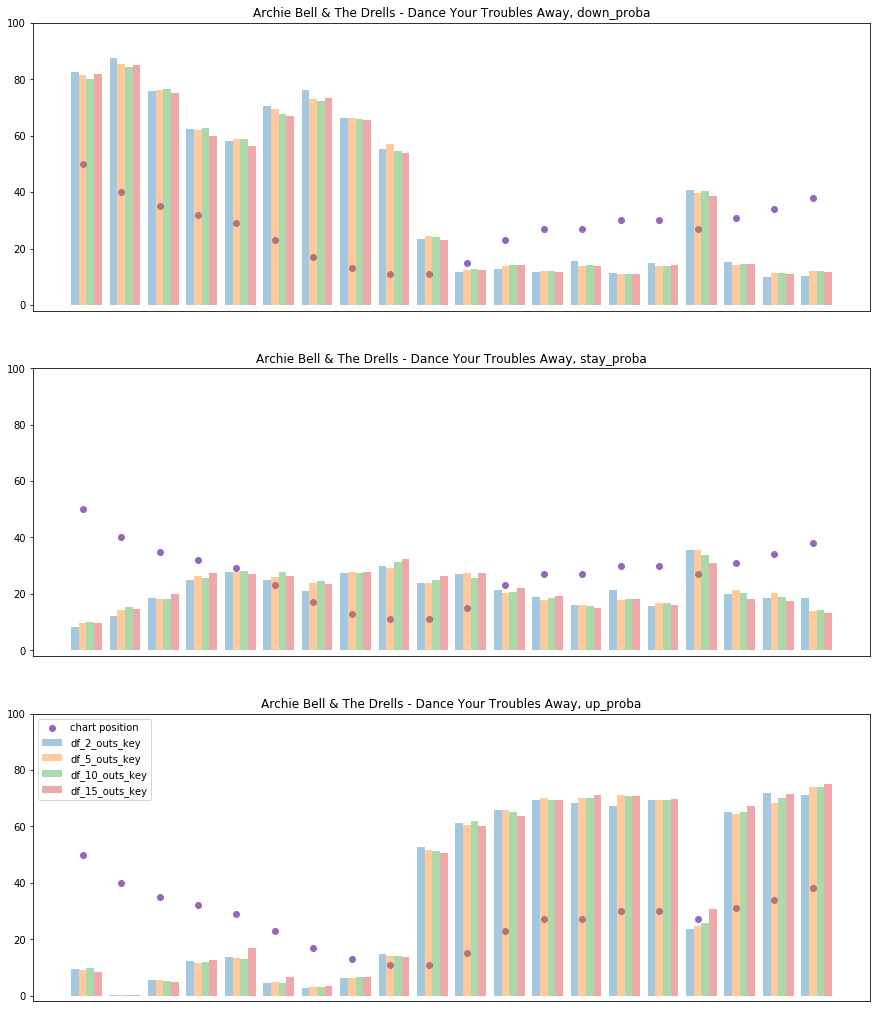

In [211]:
lags_barplots('Archie Bell & The Drells - Dance Your Troubles Away')

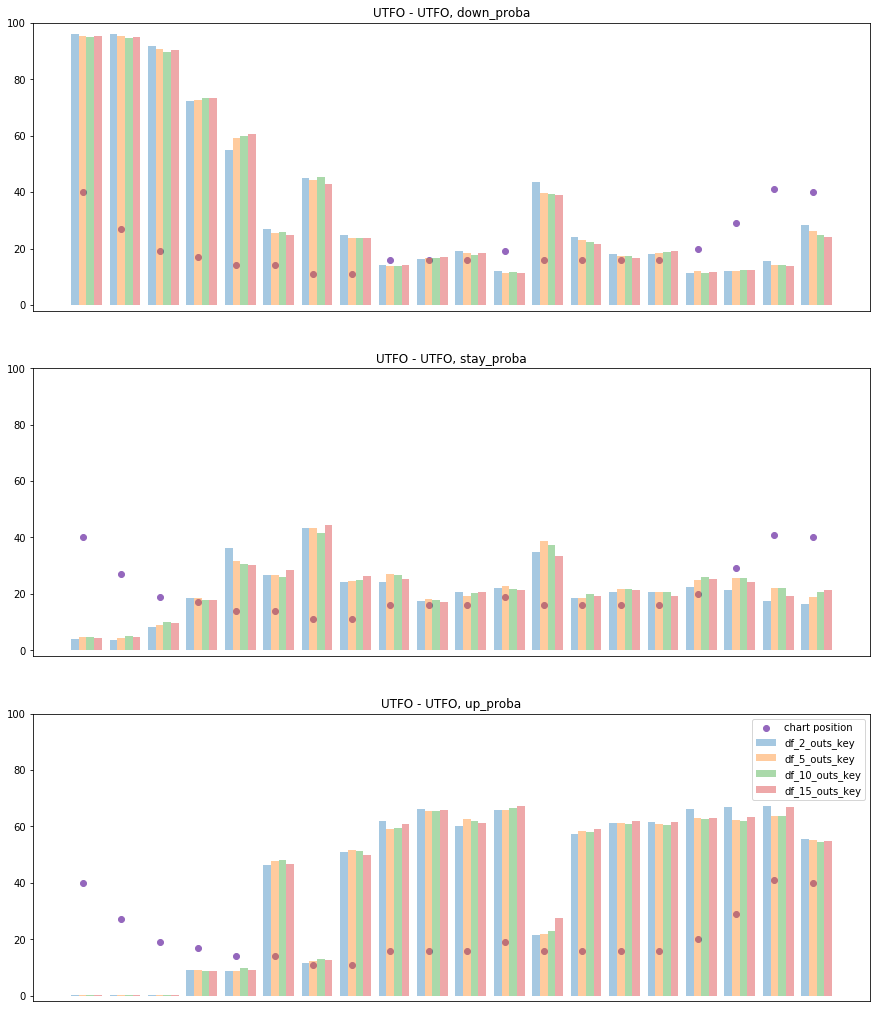

In [212]:
lags_barplots('UTFO - UTFO')